In [12]:
import casadi as ca
from casadi.tools.graph import dotgraph
from IPython.display import Image

def draw_graph(expr):
    return Image(dotgraph(expr).create_png())

In [16]:
def rhs(x, u):
    s = 2170
    cbar = 17.5
    mass = 5.0e3
    iyy = 4.1e6
    tstat = 6.0e4
    dtdv = -38.0
    ze = 2.0
    cdcls = 0.042
    cla = 0.085
    cma = -0.022
    cmde = -0.016
    cmq = -16.0
    cmadot = -6.0
    cladot = 0.0
    rtod = 57.29578
    gd = 32.17
    
    thtl = u[0]
    elev_deg = u[1]
    xcg = u[2]
    land = u[3]
    
    vt = x[0]  # velocity, ft/s
    alpha = x[1]
    alpha_deg = rtod*alpha  # angle of attack, deg
    theta = x[2]  # pitch angle, rad
    q = x[3]  # pitch rate, rad/s
    h = x[4]  # altitude, ft
    
    r0 = 2.377e-3
    tfac = 1.0 - 0.703e-5*h
    temperature = ca.if_else(h > 35000, 390.0, 519.0*tfac)
    rho = r0*tfac**4.14
    mach = vt/ca.sqrt(1.4*1716.3*temperature)
    qbar = 0.5*rho*vt**2
    
    qs = qbar*s
    salp = ca.sin(alpha)
    calp = ca.cos(alpha)
    gam = theta - alpha
    sgam = ca.sin(gam)
    cgam = ca.cos(gam)
    
    aero_p = ca.if_else(
        land,
        (0.2, 0.016, 0.05, 0.0, 0.0),
        (1.0, 0.08, -0.20, 0.02, -0.05))
    cl0 = aero_p[0]
    cd0 = aero_p[1]
    cm0 = aero_p[2]
    dcdg = aero_p[3]
    dcmg = aero_p[4]
    
    thr = (tstat + vt*dtdv)*ca.fmax(thtl, 0)
    cl = cl0 + cla*alpha_deg
    cm = dcmg + cm0 + cma*alpha_deg + cmde*elev_deg + cl*(xcg - 0.25)
    cd = dcdg + cd0 + cdcls*cl**2
    
    x_dot = ca.SX.zeros(6)
    x_dot[0] = (thr*calp - qs*cd)/mass - gd*sgam
    x_dot[1] = (-thr*salp - qs*cl + mass*(vt*q + gd*cgam))/(mass*vt + qs*cladot)
    x_dot[2] = q
    d = 0.5*cbar*(cmq*q + cmadot*x_dot[1])/vt
    x_dot[3] = (qs*cbar*(cm + d) + thr*ze)/iyy
    x_dot[4] = vt*sgam
    x_dot[5] = vt*cgam
    return x_dot
    
x = ca.SX.sym('x', 6)
u = ca.SX.sym('u', 4)
rhs(x, u)


SX(@1=((60000+(-38*x_0))*fmax(u_0,0)), @2=1, @3=(2170*((0.5*(0.002377*pow((@2-(7.03e-06*x_4)),4.14)))*sq(x_0))), @4=(!u_3), @5=(57.2958*x_1), @6=(((u_3?0.2:0)+(@4?@2:0))+(0.085*@5)), @7=5000, @8=32.17, @9=(x_2-x_1), @10=sin(@9), @11=cos(@9), @12=(((@7*((x_0*x_3)+(@8*@11)))-((@1*sin(x_1))+(@3*@6)))/(@7*x_0)), [((((@1*cos(x_1))-(@3*(((@4?0.02:0)+((u_3?0.016:0)+(@4?0.08:0)))+(0.042*sq(@6)))))/@7)-(@8*@10)), @12, x_3, ((((17.5*@3)*((((((@4?-0.05:0)+((u_3?0.05:0)+(@4?-0.2:0)))+(-0.022*@5))+(-0.016*u_1))+(@6*(u_2-0.25)))+((8.75*((-16*x_3)+(-6*@12)))/x_0)))+(2*@1))/4.1e+06), (x_0*@10), (x_0*@11)])

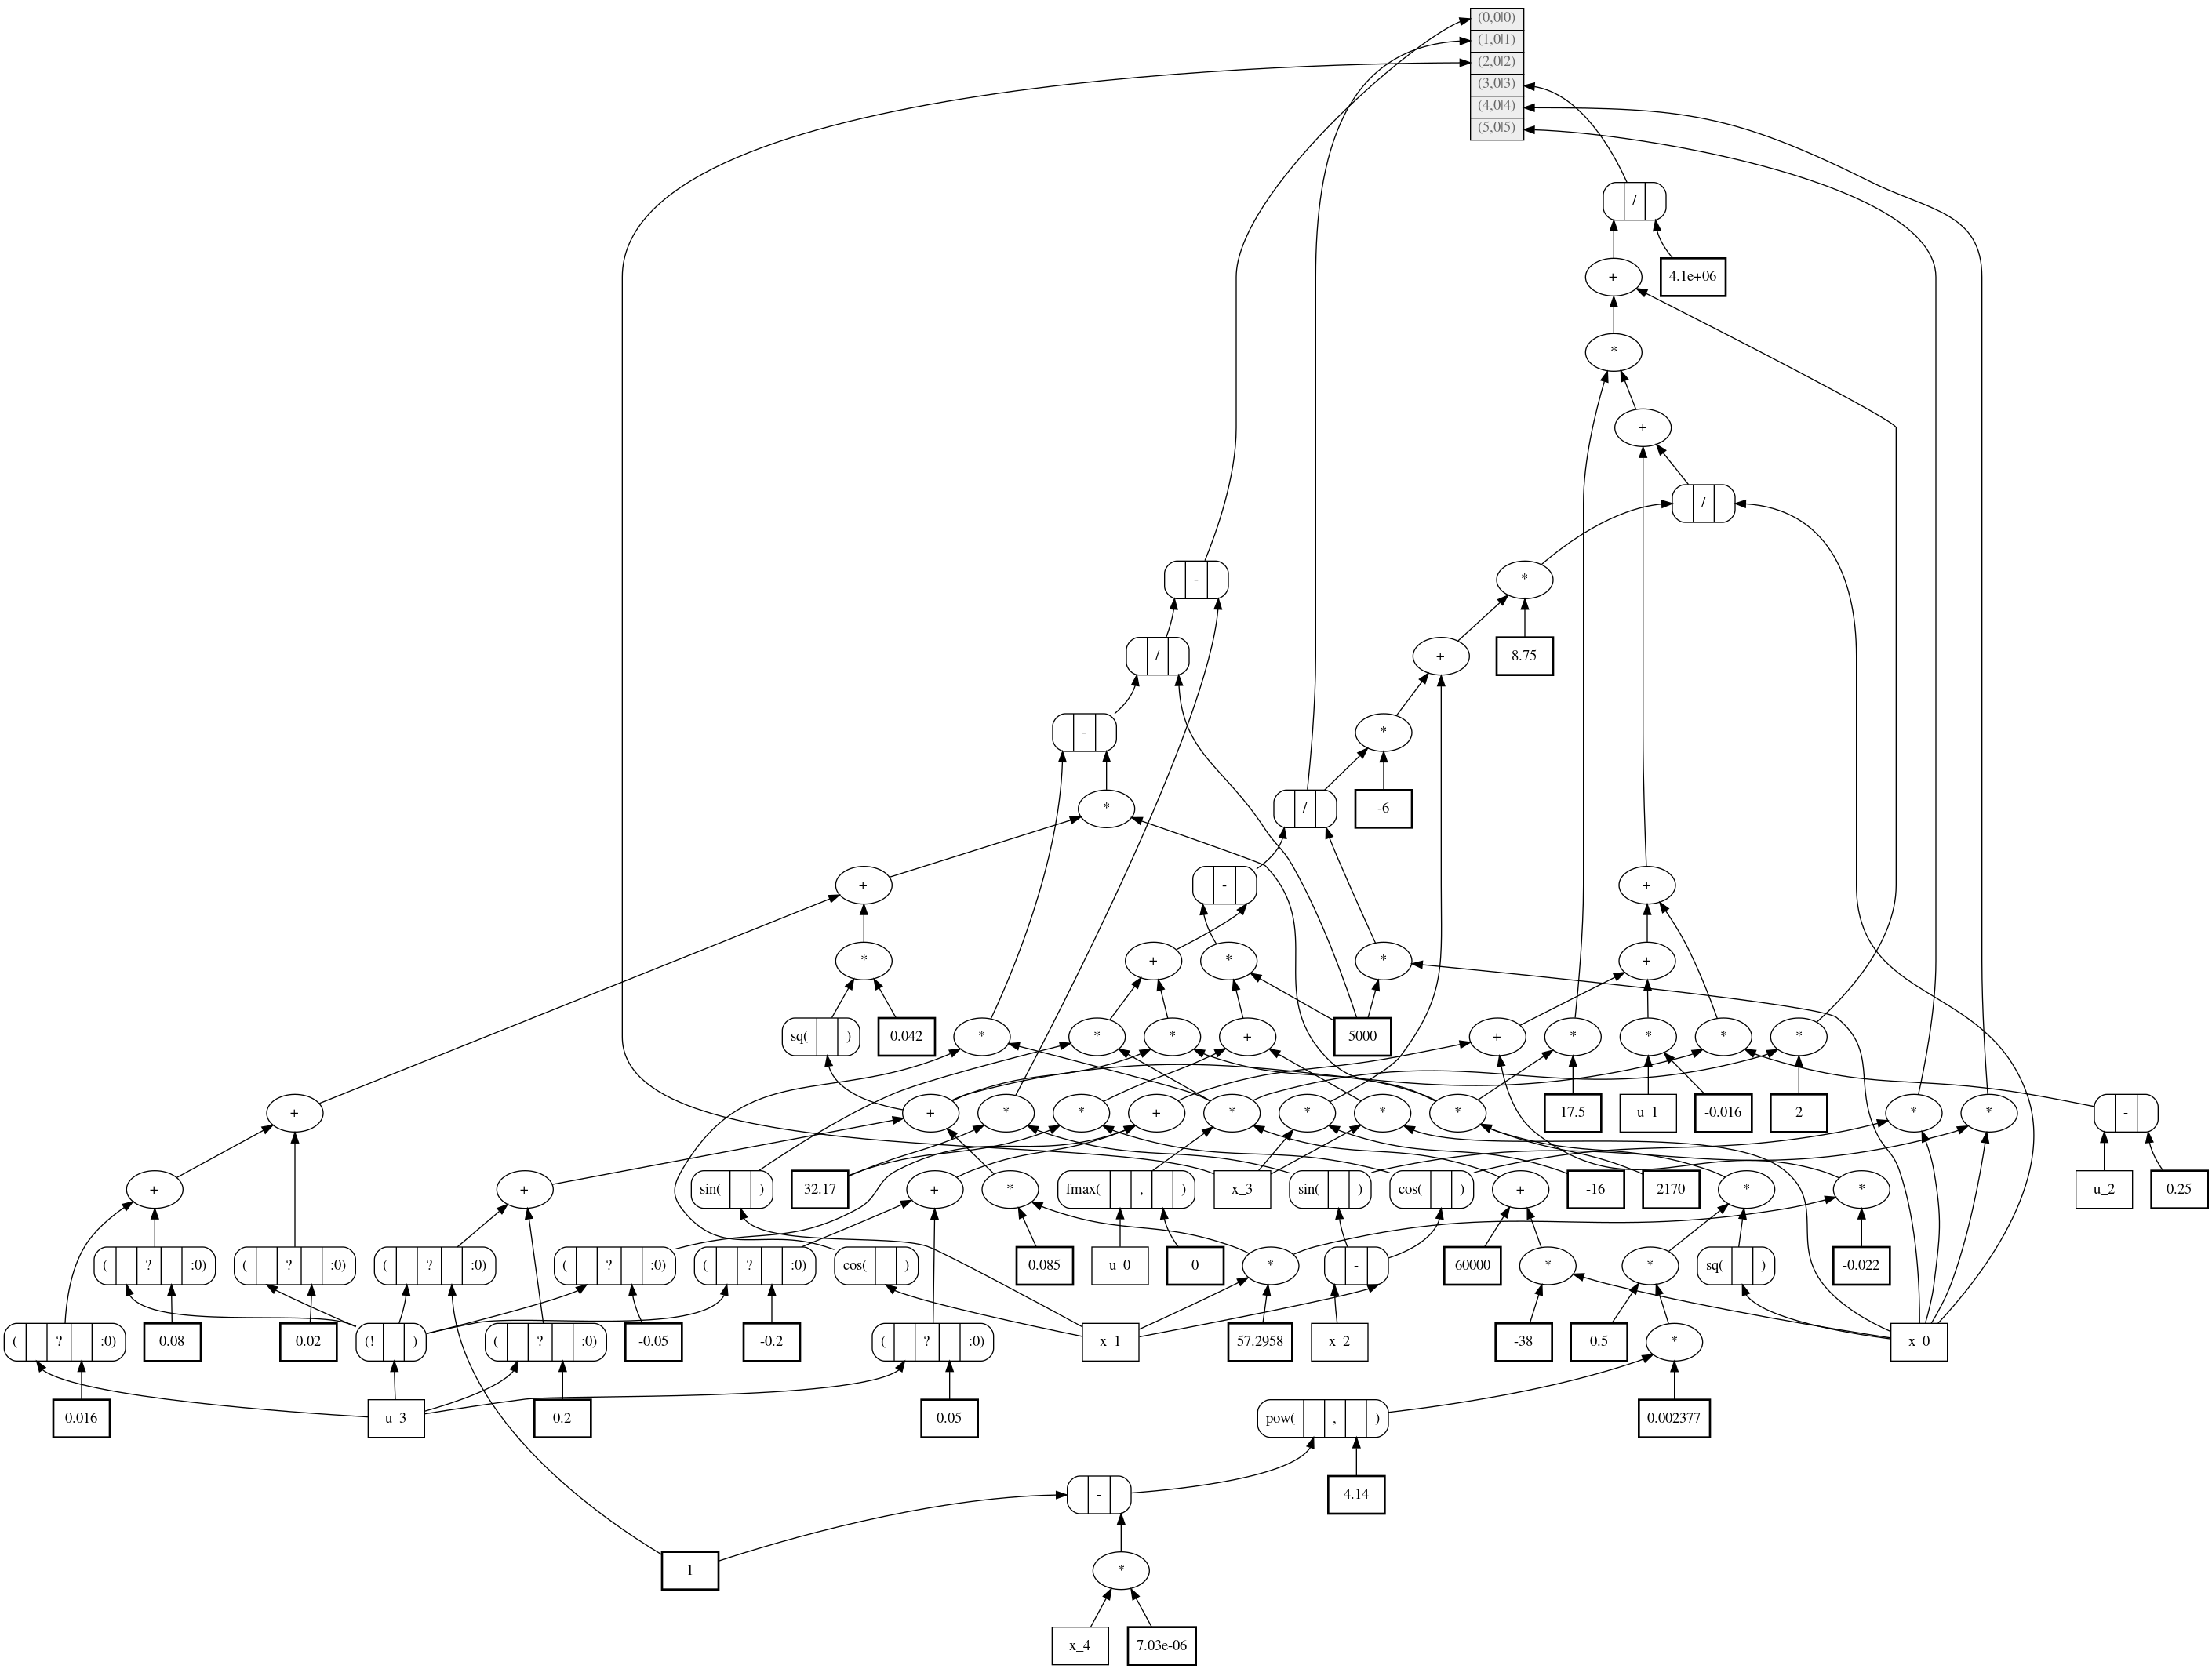

In [15]:
def objective(s):
    
    x = ca.vercat()
    u = ca.vertcat()